In [139]:
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.TSLearner import *
from tqdm.autonotebook import tqdm

In [140]:
class UCB_Learner():
    def __init__(self, n_arms, arms, n_categories, ad_id):
        self. n_arms = n_arms
        self.n_categories = n_categories
        self.ad_id = ad_id
        self.reward_per_arm = np.zeros((n_categories, n_arms)) # sum of reward of each arm in each category
        self.empirical_mean = np.ones((n_categories, n_arms))
        self.confidence = np.ones((n_categories, n_arms))*np.inf
        self.count = np.zeros((n_categories, n_arms)) # counting of how many time an arm in pulled in each category
        self.collected_rewards = []
        self.t = 0 #numver of executions
        self.c = 5.0  # exploration factor

    def pull_arm(self):
        ucb = self.empirical_mean+self.confidence
        pulled_arm = np.argmax(ucb, axis=-1)
        bids = [Bid(pulled_arm[i], self.ad_id) for i in range(5)]
        return bids

    def update(self, pulled_arm, reward):
        self.t += 1

        self.collected_rewards.append(reward)
        for i in range(self.n_categories):

            self.reward_per_arm[i][pulled_arm[i].bid] += reward[i]
            self.count[i][pulled_arm[i].bid] += 1
            #computation empirical mean reward and confidence
            self.empirical_mean[i][pulled_arm[i].bid
                                   ] = self.reward_per_arm[i][pulled_arm[i].bid]/self.count[i][pulled_arm[i].bid]
            self.confidence[i][pulled_arm[i].bid] = self.c*np.sqrt(
                2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
            #improvement to force the pulling of all arm    
        for i in range(self.n_categories):
            self.empirical_mean[i][self.count[i] == 0] = np.inf
            self.confidence[i][self.count[i] == 0] = np.inf


In [141]:
#control if the learner is present in all auction and compute the correspondent reward
def reward_control_allocation(best_allocation, ad_id, reward):
    temp = []
    for i in range(5):
        control = False
        for j in range(len(best_allocation[i])):
            if (best_allocation[i][j].ad_id == ad_id):
                control = True
                break
        if control:
            temp.append(reward)
        else:
            temp.append(0)
    return temp


In [142]:
def test(n_test=1000, learner=None, vcg=None, social_network=None):
    collected_tot = []
   
    for i in tqdm(range(n_test)):
        bids_adversaries = []
        for i in range(0, 5):
            bid_categoria = np.array([])
            for j in range(0, 10):  # number of competitors
                bid = Bid(bid=random.randint(1, 4), id=j+3)
                bid_categoria = np.append(bid_categoria, bid)
            bids_adversaries.append(bid_categoria)

        pulled_arm = learner.pull_arm()
        # add the bids of the learner into the auction
        for j in range(5):
            bids_adversaries[j][0] = pulled_arm[j]
    #the vgc calculate the best allocation        
        best_allocation = vcg.all_best_allocations(
            list_camp_bids=bids_adversaries, social_network=social_network)
    # ACTIVATE THE CASCADE OF OUR SOCIAL NETWORK AND COMPUTE THE REWARDS
        reward = activate_cascade(social_network=social_network,
                                  ad_allocation_list=best_allocation, slot_prominence=lambdas)

    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.

        temp = np.array(reward_control_allocation(best_allocation, 1, reward))

        payments = np.array(vcg.payments(
            bids_adversaries, best_allocation, social_network=social_network))

    # updating of the learners
        learner.update(pulled_arm, temp-payments)
        collected_tot.append(temp-payments)

    plt.figure(0)
    plt.plot(np.array(np.mean(collected_tot, axis=-1)), 'r')
    plt.show()


100%|██████████| 1000/1000 [00:09<00:00, 108.84it/s]


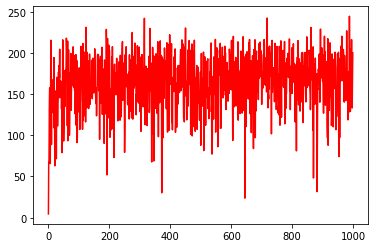

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-140-ea75e4b8a09b>:33: RuntimeWarning: invalid value encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
<ipython-input-140-ea75e4b8a09b>:33: RuntimeWarning: divide by zero encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
100%|██████████| 1000/1000 [00:06<00:00, 163.46it/s]


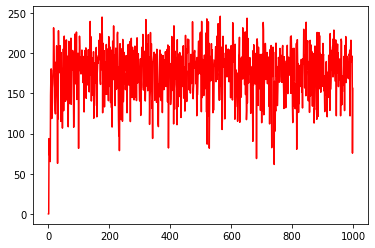

In [143]:
#setting of the environment for the test
prev_reward = 0
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')
lambdas = [0.9, 0.75, 0.7, 0.40, 0.35, 0.20]
arms = [0, 1, 2, 3, 4]
vcg = VCG()

random.seed(1234)


ts_learner = TS_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
ts_learner.max=max_reward(social_network)
ucb_learner = UCB_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
test(1000, ts_learner, vcg, social_network)
test(1000, ucb_learner,vcg, social_network)

In [ ]:
ts_learner.pull_arm()

[(bid=4, id=1), (bid=4, id=1), (bid=3, id=1), (bid=3, id=1), (bid=4, id=1)]

In [ ]:
ucb_learner.pull_arm()

[(bid=4, id=1), (bid=4, id=1), (bid=4, id=1), (bid=4, id=1), (bid=4, id=1)]